In [1]:
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
data=spark.read.csv("hotel_bookings.csv",inferSchema=True,header=True)

In [4]:
type(data)

pyspark.sql.dataframe.DataFrame

In [5]:
data.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: string (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullab

In [6]:
data.show(2)

+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+---+---------------------------+-------------------------+------------------+-----------------------+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|customer_type|adr|required_car_parking_spaces|total_of

In [7]:
data.take(2)

[Row(hotel='Resort Hotel', is_canceled=0, lead_time=342, arrival_date_year=2015, arrival_date_month='July', arrival_date_week_number=27, arrival_date_day_of_month=1, stays_in_weekend_nights=0, stays_in_week_nights=0, adults=2, children='0', babies=0, meal='BB', country='PRT', market_segment='Direct', distribution_channel='Direct', is_repeated_guest=0, previous_cancellations=0, previous_bookings_not_canceled=0, reserved_room_type='C', assigned_room_type='C', booking_changes=3, deposit_type='No Deposit', agent='NULL', company='NULL', days_in_waiting_list=0, customer_type='Transient', adr=0.0, required_car_parking_spaces=0, total_of_special_requests=0, reservation_status='Check-Out', reservation_status_date='2015-07-01'),
 Row(hotel='Resort Hotel', is_canceled=0, lead_time=737, arrival_date_year=2015, arrival_date_month='July', arrival_date_week_number=27, arrival_date_day_of_month=1, stays_in_weekend_nights=0, stays_in_week_nights=0, adults=2, children='0', babies=0, meal='BB', country='

In [3]:
#Renaming column for better readability
data=data.withColumnRenamed('is_canceled', 'Cancelled')\
.withColumnRenamed('lead_time', 'LeadTime')\
.withColumnRenamed('arrival_date_year', 'ArrivalYear')\
.withColumnRenamed('arrival_date_month', 'ArrivalMonth') \
.withColumnRenamed('arrival_date_week_number', 'ArrivalWeek')\
.withColumnRenamed('arrival_date_day_of_month', 'ArrivalDay')\
.withColumnRenamed('stays_in_weekend_nights', 'WeekendStay')\
.withColumnRenamed('stays_in_week_nights', 'WeekStay')\
.withColumnRenamed('market_segment', 'MarketSegment')\
.withColumnRenamed('distribution_channel', 'DistributionChannel')\
.withColumnRenamed('is_repeated_guest', 'RepeatedGuest')\
.withColumnRenamed('previous_cancellations', 'PreviousCancellations')\
.withColumnRenamed('previous_bookings_not_canceled', 'PreviousBookings')\
.withColumnRenamed('reserved_room_type', 'BookedRoomType')\
.withColumnRenamed('assigned_room_type', 'AssignedRoomType')\
.withColumnRenamed('booking_changes', 'BookingChanges')\
.withColumnRenamed('deposit_type', 'DepositType')\
.withColumnRenamed('days_in_waiting_list', 'WaitingListDays')\
.withColumnRenamed('adr', 'AverageDailyRate')\
.withColumnRenamed('required_car_parking_spaces', 'CarParkingSpaces')\
.withColumnRenamed('total_of_special_requests', 'SpecialRequestRate')\
.withColumnRenamed('reservation_status', 'ReservationStatus')\
.withColumnRenamed('reservation_status_date', 'ReservationDate')

In [9]:
#SHAPE OF DATAFRAME
print((data.count(),len(data.columns)))

(119390, 32)


In [10]:
data.distinct().count()

87396

In [11]:
#disply the rows which are occur more than once
data.groupBy(data.columns).count().filter('count>1').show(vertical=True)

-RECORD 0--------------------------------
 hotel                 | Resort Hotel    
 Cancelled             | 0               
 LeadTime              | 24              
 ArrivalYear           | 2015            
 ArrivalMonth          | October         
 ArrivalWeek           | 43              
 ArrivalDay            | 22              
 WeekendStay           | 0               
 WeekStay              | 3               
 adults                | 2               
 children              | 0               
 babies                | 0               
 meal                  | BB              
 country               | BEL             
 MarketSegment         | Online TA       
 DistributionChannel   | TA/TO           
 RepeatedGuest         | 0               
 PreviousCancellations | 0               
 PreviousBookings      | 0               
 BookedRoomType        | E               
 AssignedRoomType      | E               
 BookingChanges        | 0               
 DepositType           | No Deposi

In [4]:
#drop duplicates
data=data.dropDuplicates()

In [13]:
print((data.count(),len(data.columns)))

(87396, 32)


In [5]:
for c in data.columns:
    data = data.withColumn(c, f.when(f.col(c) == 'NULL', None).otherwise(f.col(c)))

In [15]:
#null value check
data.select([f.count(f.when(f.col(c).isNull(), c)).alias(c) for c in data.columns]).show(vertical =True)

-RECORD 0----------------------
 hotel                 | 0     
 Cancelled             | 0     
 LeadTime              | 0     
 ArrivalYear           | 0     
 ArrivalMonth          | 0     
 ArrivalWeek           | 0     
 ArrivalDay            | 0     
 WeekendStay           | 0     
 WeekStay              | 0     
 adults                | 0     
 children              | 0     
 babies                | 0     
 meal                  | 0     
 country               | 452   
 MarketSegment         | 0     
 DistributionChannel   | 0     
 RepeatedGuest         | 0     
 PreviousCancellations | 0     
 PreviousBookings      | 0     
 BookedRoomType        | 0     
 AssignedRoomType      | 0     
 BookingChanges        | 0     
 DepositType           | 0     
 agent                 | 12193 
 company               | 82137 
 WaitingListDays       | 0     
 customer_type         | 0     
 AverageDailyRate      | 0     
 CarParkingSpaces      | 0     
 SpecialRequestRate    | 0     
 Reserva

<AxesSubplot:>

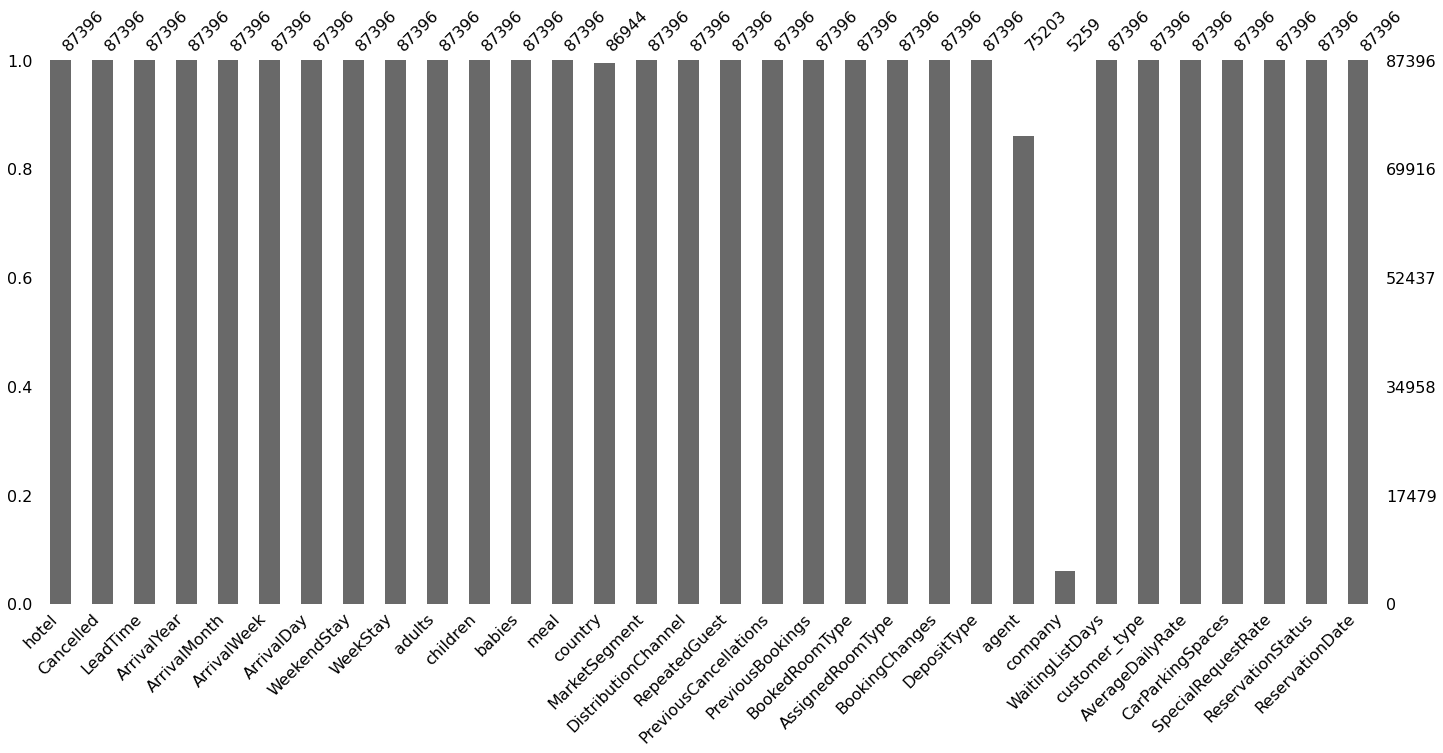

In [16]:
import missingno as msno
msno.bar(data.toPandas())

In [17]:
#analyse company column
data.groupBy(data.company).count().sort(f.desc("count")).show() #90% are null -so drop it

+-------+-----+
|company|count|
+-------+-----+
|   null|82137|
|     40|  851|
|    223|  503|
|     45|  238|
|    153|  206|
|    154|  133|
|    219|  131|
|    174|  121|
|    281|  119|
|    233|   95|
|     51|   80|
|    405|   77|
|     94|   76|
|     47|   62|
|    331|   60|
|    169|   53|
|    135|   52|
|    110|   48|
|     91|   46|
|     62|   44|
+-------+-----+
only showing top 20 rows



In [18]:
#analyse agent column
data.groupBy(data.agent).count().sort(f.desc("count")).show()  #null value is high and not so useful drop it

+-----+-----+
|agent|count|
+-----+-----+
|    9|28759|
|  240|13028|
| null|12193|
|   14| 3349|
|    7| 3300|
|  250| 2779|
|  241| 1644|
|   28| 1502|
|    8| 1383|
|    1| 1232|
|    6| 1117|
|   40|  986|
|  314|  844|
|  242|  722|
|   83|  614|
|   85|  524|
|  243|  477|
|  171|  402|
|   27|  395|
|    3|  363|
+-----+-----+
only showing top 20 rows



In [19]:
#analyse country
data.groupBy(data.country).count().sort(f.desc("count")).show()  

+-------+-----+
|country|count|
+-------+-----+
|    PRT|27453|
|    GBR|10433|
|    FRA| 8837|
|    ESP| 7252|
|    DEU| 5387|
|    ITA| 3066|
|    IRL| 3016|
|    BEL| 2081|
|    BRA| 1995|
|    NLD| 1911|
|    USA| 1875|
|    CHE| 1570|
|     CN| 1093|
|    AUT|  947|
|    SWE|  837|
|    CHN|  816|
|    POL|  765|
|    RUS|  561|
|    NOR|  515|
|    ROU|  458|
+-------+-----+
only showing top 20 rows



In [20]:
df3 = data.select(f.countDistinct("agent")).show()
df3

+---------------------+
|count(DISTINCT agent)|
+---------------------+
|                  333|
+---------------------+



In [6]:
#replace country null values with mode
data=data.fillna('PRT', subset=['country'])

In [7]:
#Drop agent and company column
data=data.drop("agent","company")
print(len(data.columns))

30


In [24]:
#Analyse other columns
data.select([f.collect_set(c).alias(c) for c in data.columns]).show(truncate=False,vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
data.groupBy('children').count().sort(f.desc("count")).show()
data.groupBy('Meal').count().sort(f.desc("count")).show()

+--------+-----+
|children|count|
+--------+-----+
|       0|79028|
|       1| 4695|
|       2| 3593|
|       3|   75|
|      NA|    4|
|      10|    1|
+--------+-----+

+---------+-----+
|     Meal|count|
+---------+-----+
|       BB|67978|
|       SC| 9481|
|       HB| 9085|
|Undefined|  492|
|       FB|  360|
+---------+-----+



In [26]:
data.groupBy('MarketSegment').count().sort(f.desc("count")).show()
data.groupBy('DistributionChannel').count().sort(f.desc("count")).show()

+-------------+-----+
|MarketSegment|count|
+-------------+-----+
|    Online TA|51618|
|Offline TA/TO|13889|
|       Direct|11804|
|       Groups| 4942|
|    Corporate| 4212|
|Complementary|  702|
|     Aviation|  227|
|    Undefined|    2|
+-------------+-----+

+-------------------+-----+
|DistributionChannel|count|
+-------------------+-----+
|              TA/TO|69141|
|             Direct|12988|
|          Corporate| 5081|
|                GDS|  181|
|          Undefined|    5|
+-------------------+-----+



In [8]:
#drop row with zero guests
data=data.where(~((data.adults==0) & (data.children == 0) & (data.babies ==0)))

In [9]:
#Replace NA values of  children colum 
data = data.withColumn("children",f.when(f.col("children") == 'NA','0').otherwise(f.col("children")))

In [10]:
data = data.withColumn("Meal",f.when(f.col("Meal") == 'Undefined','SC').otherwise(f.col("Meal"))) \
.withColumn("MarketSegment",f.when(f.col("MarketSegment") == 'Undefined',"Online TA").otherwise(f.col("MarketSegment"))) \
.withColumn("DistributionChannel",f.when(f.col("DistributionChannel") == 'Undefined',"TA/TO").otherwise(f.col("DistributionChannel"))) 

In [11]:
data=data.drop("ArrivalYear","ArrivalWeek","ArrivalDay","ReservationDate","ReservationStatus")

In [12]:
data.groupBy('AverageDailyRate').count().sort(f.desc("count")).show()

+----------------+-----+
|AverageDailyRate|count|
+----------------+-----+
|             0.0| 1643|
|            75.0| 1320|
|            65.0| 1260|
|            48.0|  878|
|            85.0|  858|
|            95.0|  850|
|            90.0|  817|
|            80.0|  754|
|            99.0|  749|
|            60.0|  730|
|           120.0|  704|
|           126.0|  699|
|           108.0|  656|
|           140.0|  567|
|            79.2|  532|
|           110.0|  521|
|            89.1|  517|
|           160.0|  511|
|            68.0|  509|
|            88.0|  508|
+----------------+-----+
only showing top 20 rows



In [13]:
#mean of ADR column
ADR_Mean=data.agg((f.avg("AverageDailyRate"))).first()["avg(AverageDailyRate)"]
ADR_Mean

106.518030723375

In [14]:
#Replace 0 ADR with its mean
data = data.withColumn("AverageDailyRate",f.when(f.col("AverageDailyRate") == 0,ADR_Mean).otherwise(f.col("AverageDailyRate"))) 

In [124]:
data.filter(data.AverageDailyRate == 0).count()

0

In [15]:
#merge assigned_room_type and reserved_room_type and make it as a single column
data = data.withColumn("RoomType",f.when(f.col("BookedRoomType") != f.col("AssignedRoomType") ,1).otherwise(0))
data.show(vertical=True)

-RECORD 0---------------------------------
 hotel                 | Resort Hotel     
 Cancelled             | 1                
 LeadTime              | 45               
 ArrivalMonth          | July             
 WeekendStay           | 1                
 WeekStay              | 3                
 adults                | 3                
 children              | 0                
 babies                | 0                
 Meal                  | BB               
 country               | PRT              
 MarketSegment         | Online TA        
 DistributionChannel   | TA/TO            
 RepeatedGuest         | 0                
 PreviousCancellations | 0                
 PreviousBookings      | 0                
 BookedRoomType        | D                
 AssignedRoomType      | D                
 BookingChanges        | 0                
 DepositType           | No Deposit       
 WaitingListDays       | 0                
 customer_type         | Transient        
 AverageDai

In [16]:
#drop assigned_room_type and reserved_room_type 
data=data.drop("BookedRoomType","AssignedRoomType")
data.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- LeadTime: integer (nullable = true)
 |-- ArrivalMonth: string (nullable = true)
 |-- WeekendStay: integer (nullable = true)
 |-- WeekStay: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: string (nullable = true)
 |-- babies: integer (nullable = true)
 |-- Meal: string (nullable = true)
 |-- country: string (nullable = false)
 |-- MarketSegment: string (nullable = true)
 |-- DistributionChannel: string (nullable = true)
 |-- RepeatedGuest: integer (nullable = true)
 |-- PreviousCancellations: integer (nullable = true)
 |-- PreviousBookings: integer (nullable = true)
 |-- BookingChanges: integer (nullable = true)
 |-- DepositType: string (nullable = true)
 |-- WaitingListDays: integer (nullable = true)
 |-- customer_type: string (nullable = true)
 |-- AverageDailyRate: double (nullable = true)
 |-- CarParkingSpaces: integer (nullable = true)
 |-- SpecialRequestRate: in

In [36]:
numColumns= [x for (x,dataType) in data.dtypes if dataType !="string"]
print(numColumns)

['Cancelled', 'LeadTime', 'WeekendStay', 'WeekStay', 'adults', 'babies', 'RepeatedGuest', 'PreviousCancellations', 'PreviousBookings', 'BookingChanges', 'WaitingListDays', 'AverageDailyRate', 'CarParkingSpaces', 'SpecialRequestRate', 'RoomType']


In [37]:
numericDataset=data.select(numColumns)

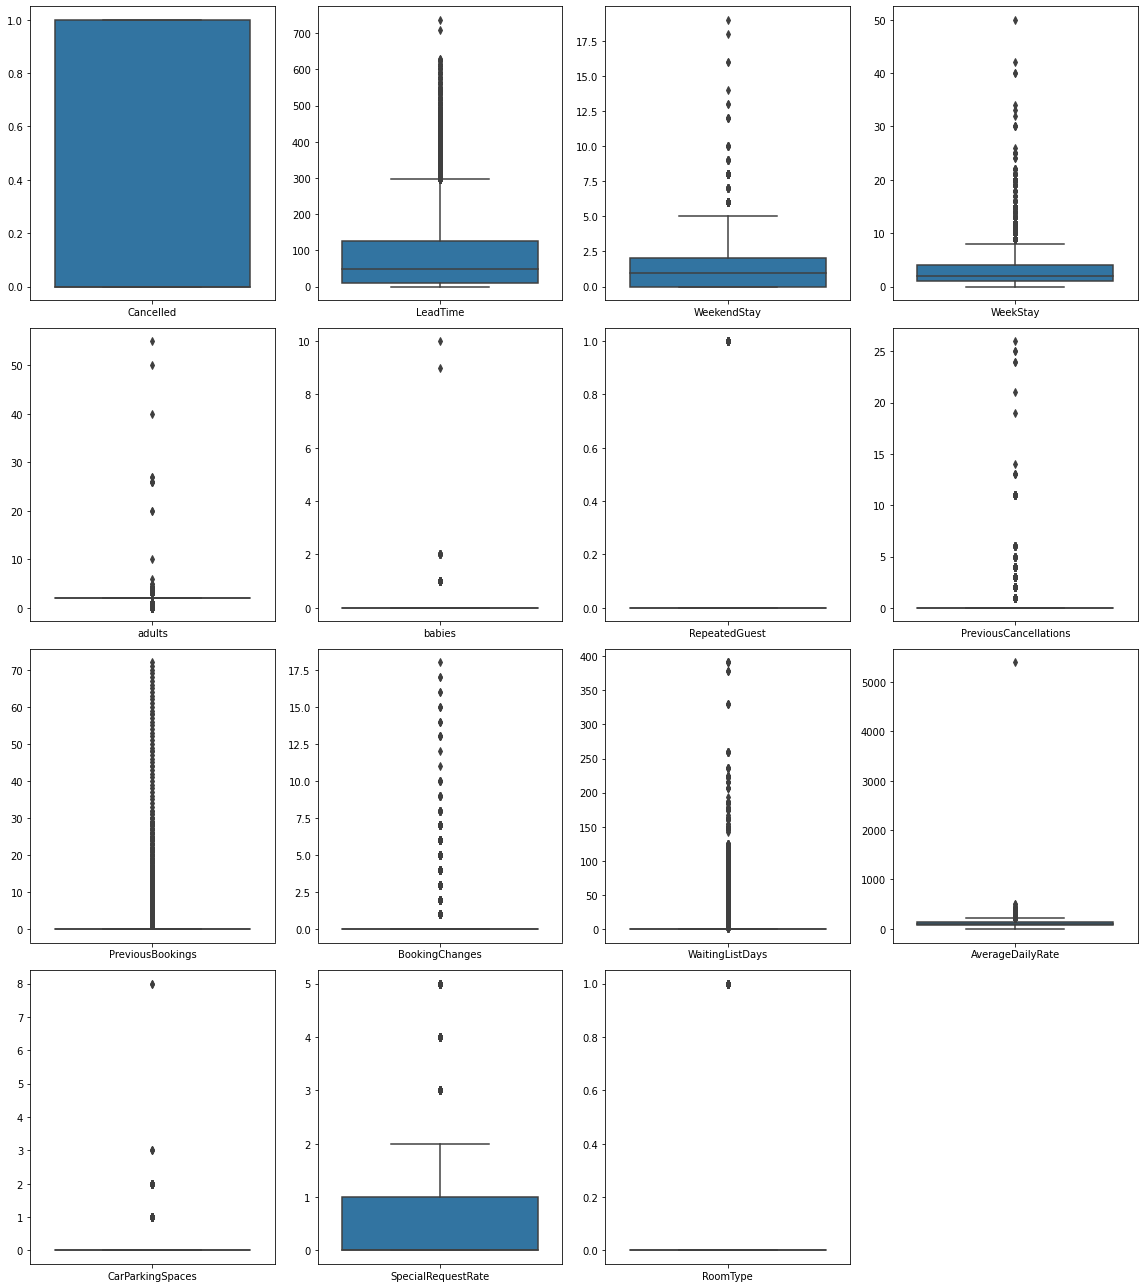

In [38]:
#checking for outliers
n=1
plt.figure(figsize=(16,18))
for feature in numericDataset.columns:
    x=numericDataset.select(feature).toPandas()
    plt.subplot(4,4,n)
    sns.boxplot(data=x)
    n+=1
    plt.tight_layout()

In [38]:
bounds = {
    c: dict(
        zip(["q1", "q3"], numericDataset.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in numColumns
}

In [39]:
for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)
print(bounds)

{'Cancelled': {'q1': 0.0, 'q3': 1.0, 'lower': -1.5, 'upper': 2.5}, 'LeadTime': {'q1': 11.0, 'q3': 125.0, 'lower': -160.0, 'upper': 296.0}, 'WeekendStay': {'q1': 0.0, 'q3': 2.0, 'lower': -3.0, 'upper': 5.0}, 'WeekStay': {'q1': 1.0, 'q3': 4.0, 'lower': -3.5, 'upper': 8.5}, 'adults': {'q1': 2.0, 'q3': 2.0, 'lower': 2.0, 'upper': 2.0}, 'babies': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'RepeatedGuest': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'PreviousCancellations': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'PreviousBookings': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'BookingChanges': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'WaitingListDays': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'AverageDailyRate': {'q1': 74.8, 'q3': 134.1, 'lower': -14.149999999999991, 'upper': 223.04999999999998}, 'CarParkingSpaces': {'q1': 0.0, 'q3': 0.0, 'lower': 0.0, 'upper': 0.0}, 'SpecialRequestRate': {'q1': 0.0, 'q3': 1.0, 'lower': -1.5, 'upper'

In [40]:
#IQR Method
num_var = ["LeadTime","WeekendStay","WeekStay","AverageDailyRate"]
for col in num_var:
    data = data.withColumn(col, \
    f.when(data[col] < bounds[col]["lower"],round(bounds[col]["lower"]))\
    .when(data[col] > bounds[col]["upper"],round(bounds[col]["upper"]))\
    .otherwise(data[col]))

In [41]:
#Handling outliers-Dataframe operation
data = data.withColumn("adults",f.when(f.col("adults")>4,4).otherwise(f.col("adults"))) \
.withColumn("children",f.when(f.col("children")>8,0).otherwise(f.col("children"))) \
.withColumn("WaitingListDays",f.when(f.col("WaitingListDays")>10,0).otherwise(f.col("WaitingListDays"))) \
.withColumn("babies",f.when(f.col("babies")>2,0).otherwise(f.col("babies"))) \
.withColumn("PreviousBookings",f.when(f.col("PreviousBookings")>0,1).otherwise(f.col("PreviousBookings"))) \
.withColumn("BookingChanges",f.when(f.col("BookingChanges")>10,10).otherwise(f.col("BookingChanges"))) \
.withColumn("CarParkingSpaces",f.when(f.col("CarParkingSpaces")>3,3).otherwise(f.col("CarParkingSpaces")))

In [43]:
from pyspark.mllib.stat import Statistics
data_num=data.select(numColumns)
import pandas as pd
col_names =data_num.columns
features = data_num.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_data = pd.DataFrame(corr_mat)
corr_data.index, corr_data.columns = col_names, col_names
corr_data

Cancelled  LeadTime  WeekendStay  WeekStay    adults  \
Cancelled               1.000000  0.188370     0.060629  0.087451  0.086588   
LeadTime                0.188370  1.000000     0.255482  0.354996  0.159409   
WeekendStay             0.060629  0.255482     1.000000  0.481096  0.114469   
WeekStay                0.087451  0.354996     0.481096  1.000000  0.141290   
adults                  0.086588  0.159409     0.114469  0.141290  1.000000   
babies                 -0.021220 -0.002171     0.016284  0.022971  0.024028   
RepeatedGuest          -0.088764 -0.151504    -0.109007 -0.125686 -0.203316   
PreviousCancellations   0.051501  0.005343    -0.021288 -0.020876 -0.051543   
PreviousBookings       -0.103675 -0.142062    -0.103759 -0.118266 -0.233811   
BookingChanges         -0.094931  0.081021     0.030208  0.062718 -0.043421   
WaitingListDays         0.009488  0.001487     0.000316 -0.001013 -0.003846   
AverageDailyRate        0.126690  0.017251     0.022939  0.047643  0.326734   
CarParkingSpaces       -0.185664 -0.089429    -0.043790 -0.046817  0.010865   
SpecialRequestRate     -0.120794  0.040673     0.034069  0.045755  0.144755   
RoomType               -0.213363 -0.110857    -0.116857 -0.134317 -0.077798   

                         babies  RepeatedGuest  PreviousCancellations  \
Cancelled             -0.021220      -0.088764               0.051501   
LeadTime              -0.002171      -0.151504               0.005343   
WeekendStay            0.016284      -0.109007              -0.021288   
WeekStay               0.022971      -0.125686              -0.020876   
adults                 0.024028      -0.203316              -0.051543   
babies                 1.000000      -0.013569              -0.005714   
RepeatedGuest         -0.013569       1.000000               0.207252   
PreviousCancellations -0.005714       0.207252               1.000000   
PreviousBookings      -0.016507       0.802362               0.193916   
BookingChanges         0.091042       0.007611              -0.010394   
WaitingListDays       -0.001836      -0.001232               0.003208   
AverageDailyRate       0.030182      -0.122432              -0.048882   
CarParkingSpaces       0.034628       0.071539              -0.003474   
SpecialRequestRate     0.103940      -0.001160               0.001695   
RoomType               0.012965       0.083958              -0.009584   

                       PreviousBookings  BookingChanges  WaitingListDays  \
Cancelled                     -0.103675       -0.094931         0.009488   
LeadTime                      -0.142062        0.081021         0.001487   
WeekendStay                   -0.103759        0.030208         0.000316   
WeekStay                      -0.118266        0.062718        -0.001013   
adults                        -0.233811       -0.043421        -0.003846   
babies                        -0.016507        0.091042        -0.001836   
RepeatedGuest                  0.802362        0.007611        -0.001232   
PreviousCancellations          0.193916       -0.010394         0.003208   
PreviousBookings               1.000000        0.011398        -0.001453   
BookingChanges                 0.011398        1.000000         0.011227   
WaitingListDays               -0.001453        0.011227         1.000000   
AverageDailyRate              -0.142294        0.016300        -0.006678   
CarParkingSpaces               0.091531        0.052187        -0.002066   
SpecialRequestRate             0.005809        0.017719        -0.015020   
RoomType                       0.101393        0.069013        -0.003906   

                       AverageDailyRate  CarParkingSpaces  SpecialRequestRate  \
Cancelled                      0.126690         -0.185664           -0.120794   
LeadTime                       0.017251         -0.089429            0.040673   
WeekendStay                    0.022939         -0.043790            0.034069   
WeekStay                       0.047643         

In [44]:
data.describe(['LeadTime']).show()

+-------+-----------------+
|summary|         LeadTime|
+-------+-----------------+
|  count|            87230|
|   mean|78.44279491000802|
| stddev|81.05273082833722|
|    min|                0|
|    max|              296|
+-------+-----------------+



In [45]:
data.summary().show(vertical=True)

-RECORD 0-------------------------------------
 summary               | count                
 hotel                 | 87230                
 Cancelled             | 87230                
 LeadTime              | 87230                
 ArrivalMonth          | 87230                
 WeekendStay           | 87230                
 WeekStay              | 87230                
 adults                | 87230                
 children              | 87230                
 babies                | 87230                
 Meal                  | 87230                
 country               | 87230                
 MarketSegment         | 87230                
 DistributionChannel   | 87230                
 RepeatedGuest         | 87230                
 PreviousCancellations | 87230                
 PreviousBookings      | 87230                
 BookingChanges        | 87230                
 DepositType           | 87230                
 WaitingListDays       | 87230                
 customer_typ

In [46]:
#Total booking count of each hotel
result_df = data.groupBy("hotel").count().sort("hotel", ascending=False)
result_df.show(10)

+------------+-----+
|       hotel|count|
+------------+-----+
|Resort Hotel|33956|
|  City Hotel|53274|
+------------+-----+



In [47]:
#overview of cancelled bookimg booking - Majority of booking is not cancelled
booking=data.groupby("Cancelled").count().show()

+---------+-----+
|Cancelled|count|
+---------+-----+
|        1|24009|
|        0|63221|
+---------+-----+



In [48]:
#GRouping hotels with cancellation count -Cancellation is higjer in city hotel
Iscancelled_count = data.groupby("hotel").agg({'Cancelled': "sum"}).toPandas()
print(Iscancelled_count)

          hotel  sum(Cancelled)
0    City Hotel           16035
1  Resort Hotel            7974


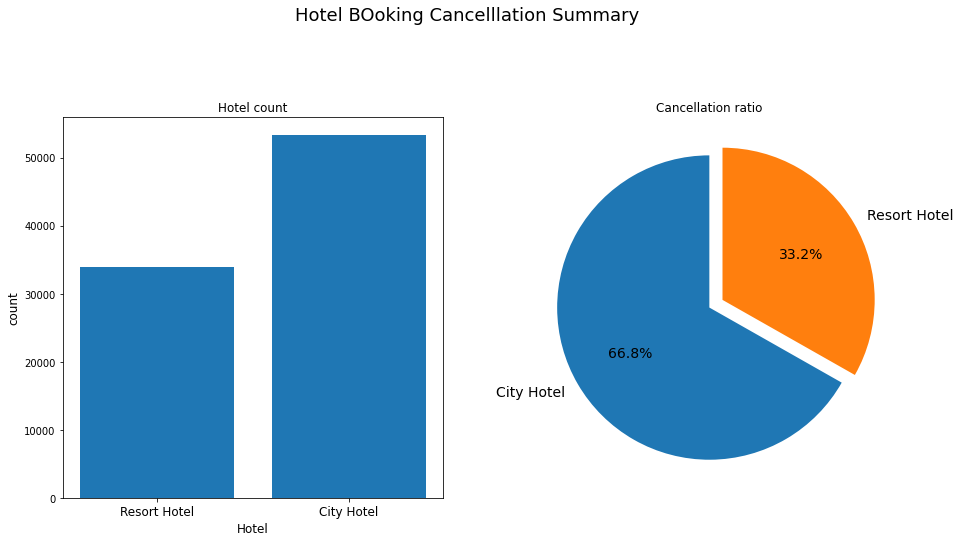

In [49]:
#bar chart
result_df = data.groupBy("hotel").count().sort("hotel", ascending=False).toPandas()
#piechart
Iscancelled_count = data.groupby("hotel").agg({'Cancelled': "sum"}).toPandas()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
plot0 =   axs[0].bar(x=result_df["hotel"]
                     ,height=result_df["count"])
title0 =  axs[0].set_title('Hotel count', fontsize = '12')
xlabel0 = axs[0].set_xlabel('Hotel', fontsize = '12')
ylabel0 = axs[0].set_ylabel('count', fontsize = '12')
xsticks_label = axs[0].set_xticklabels(result_df["hotel"]
                                       ,rotation = 'horizontal', fontsize='12')
explode = (0, 0.1)
title1 = axs[1].set_title('Cancellation ratio', fontsize = '12')
plot1 = axs[1].pie(
      Iscancelled_count["sum(Cancelled)"],labels=Iscancelled_count["hotel"] ,explode=explode, autopct='%1.1f%%',startangle=90, textprops={'fontsize': 14}
)

text = fig.text(0.5, 1.10, 'Hotel BOoking Cancelllation Summary', ha='center', va='top', transform=fig.transFigure,fontsize = '18')

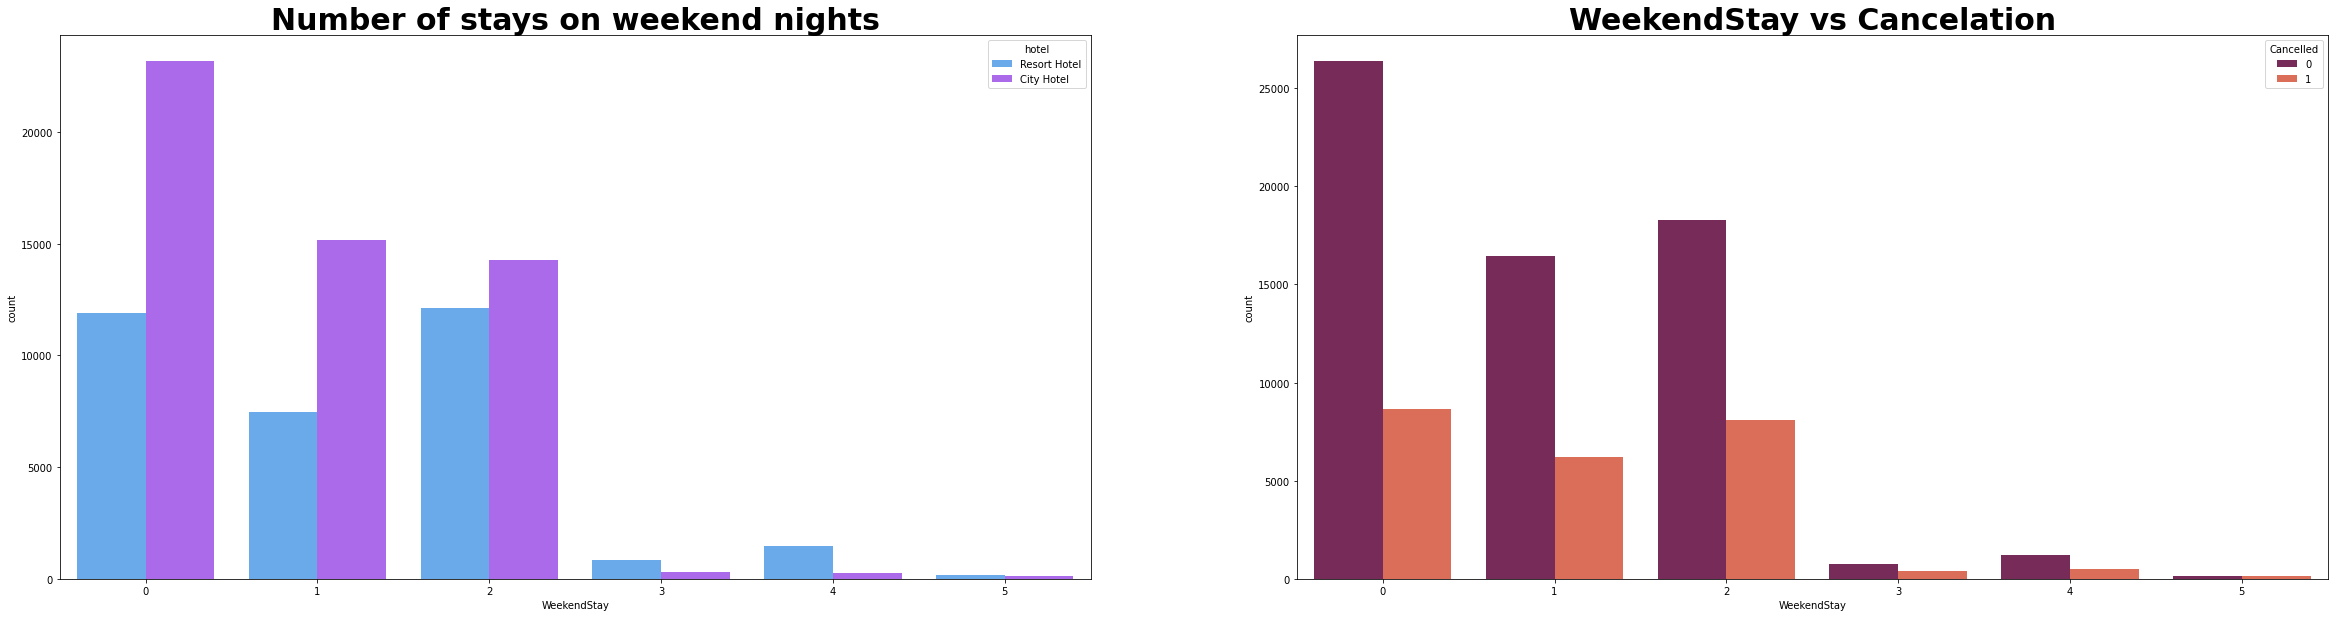

In [50]:
#weekend stay data evaluation
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.countplot(x='WeekendStay',hue='hotel', data=data.toPandas(), palette='cool')
plt.title("Number of stays on weekend nights",fontweight="bold", size=30)
plt.subplot(1, 2, 2)
sns.countplot(x = 'WeekendStay', hue='Cancelled', data=data.toPandas(),palette='rocket')
plt.title('WeekendStay vs Cancelation',fontweight="bold", size=30)
plt.subplots_adjust(right=1.7)

plt.show()

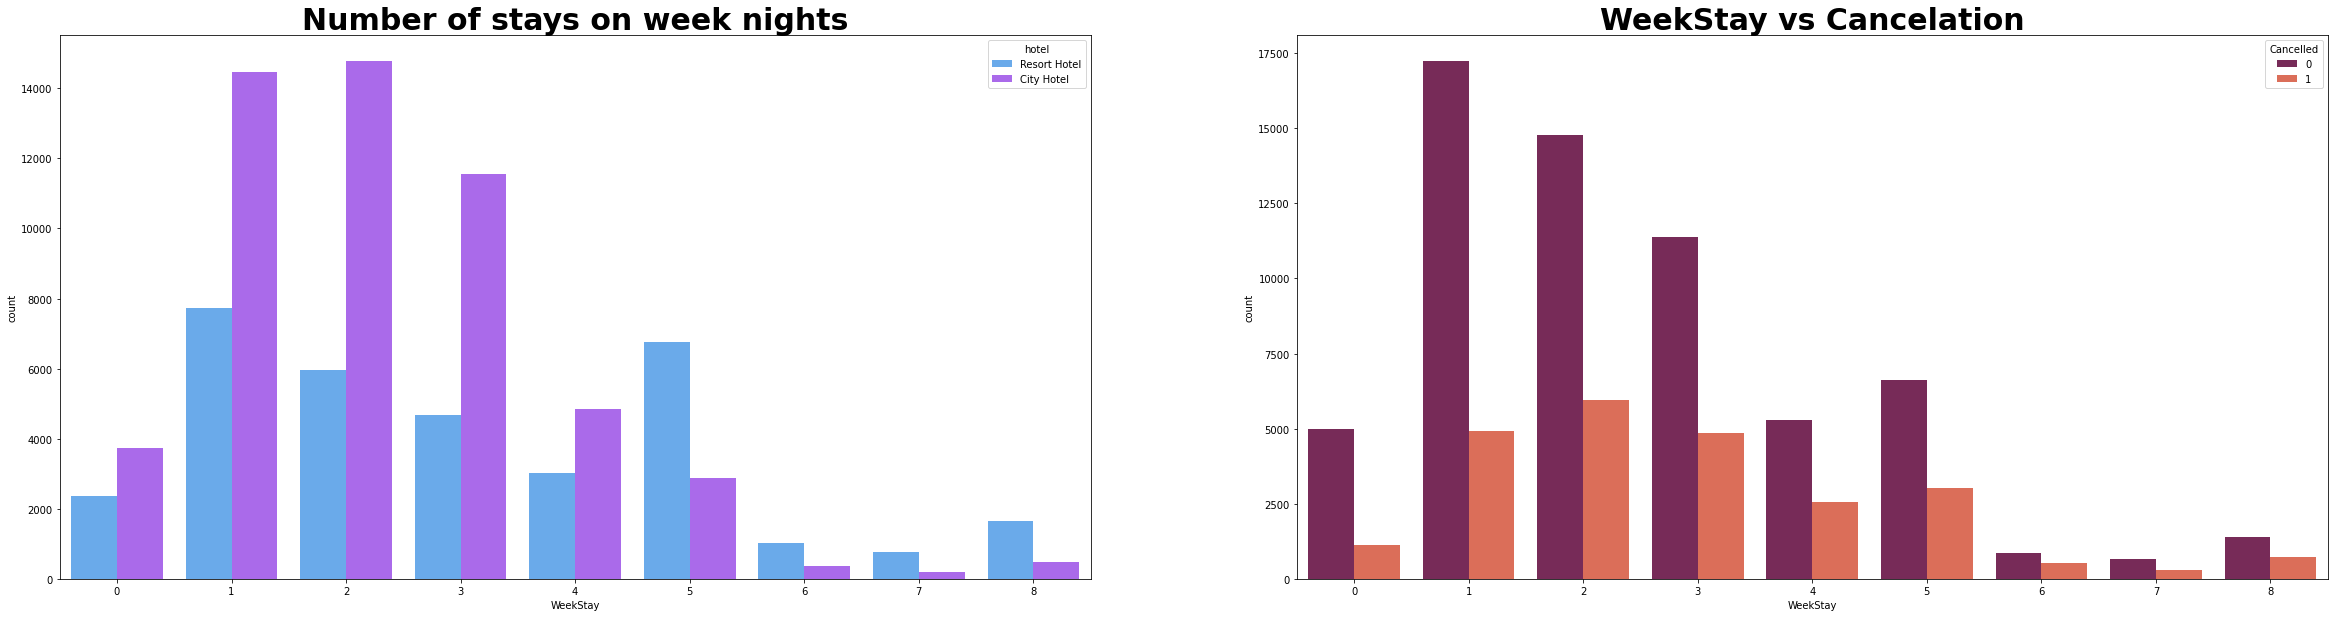

In [51]:
#weekend stay data evaluation
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.countplot(x='WeekStay',hue='hotel', data=data.toPandas(), palette='cool')
plt.title("Number of stays on week nights",fontweight="bold", size=30)
plt.subplot(1, 2, 2)
sns.countplot(x = 'WeekStay', hue='Cancelled', data=data.toPandas(),palette='rocket')
plt.title('WeekStay vs Cancelation',fontweight="bold", size=30)
plt.subplots_adjust(right=1.7)

plt.show()

In [17]:
#Analysis of country
#Taken on;y account the count of not cancelled bookings
country_visitors=data.filter(data.Cancelled !=1).groupBy('country').count().sort(f.desc("count")).toPandas()
country_visitors

country  count
0       PRT  17991
1       GBR   8440
2       FRA   7091
3       ESP   5382
4       DEU   4332
..      ...    ...
160     KIR      1
161     PYF      1
162     MMR      1
163     PLW      1
164     ATF      1

[165 rows x 2 columns]

In [18]:
px.choropleth(country_visitors,
                    locations = "country",
                    color= "count", 
                    hover_name= "country",# column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Country")

In [54]:
data1=data.toPandas()

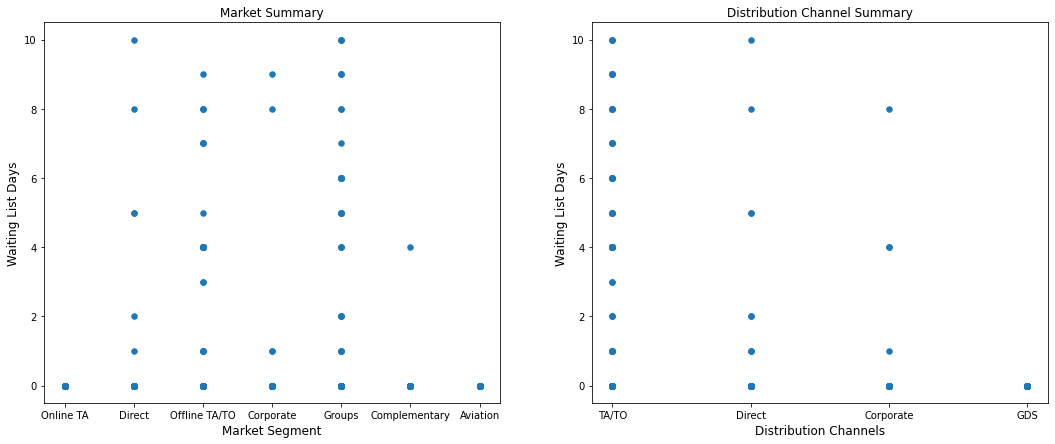

In [55]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
plot0 =   axs[0].scatter(data1['MarketSegment'], data1['WaitingListDays'],s=30)
title0 =  axs[0].set_title('Market Summary', fontsize = '12')
xlabel0 = axs[0].set_xlabel('Market Segment', fontsize = '12')
ylabel0 = axs[0].set_ylabel('Waiting List Days', fontsize = '12')
title1 = axs[1].set_title('Cancellation ratio', fontsize = '12')
plot1 = axs[1].scatter(data1['DistributionChannel'], data1['WaitingListDays'],s=30)
title1 =  axs[1].set_title('Distribution Channel Summary', fontsize = '12')
xlabel1 = axs[1].set_xlabel('Distribution Channels', fontsize = '12')
ylabel1 = axs[1].set_ylabel('Waiting List Days', fontsize = '12')


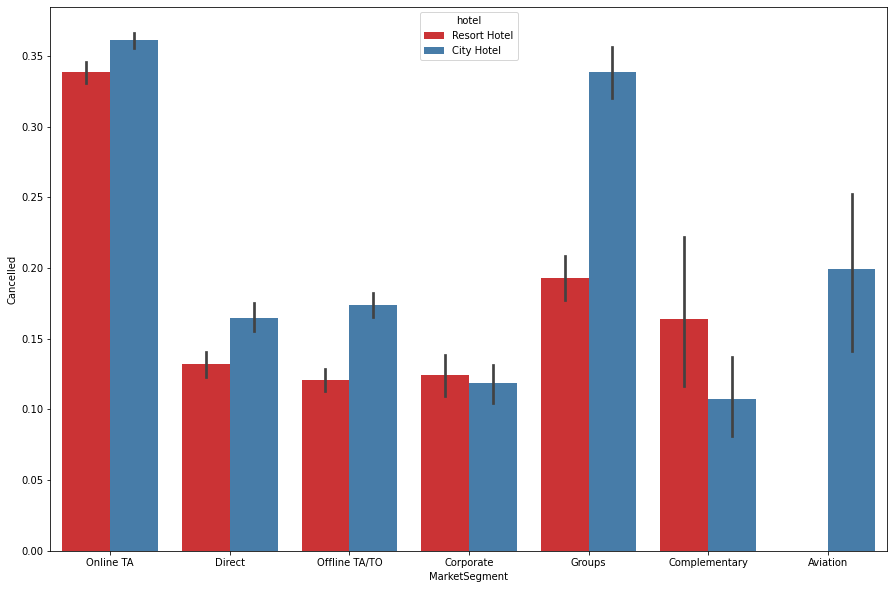

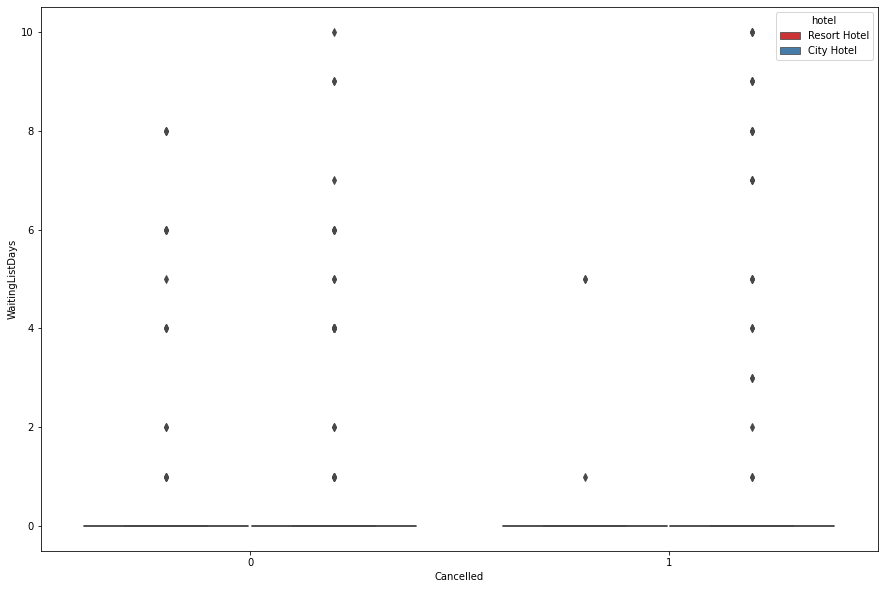

In [56]:
plt.figure(figsize = (15,10))
sns.barplot(x = "MarketSegment", y = "Cancelled", data = data1, hue = "hotel", palette = 'Set1');
plt.figure(figsize = (15,10))
sns.boxplot(x = "Cancelled", y = "WaitingListDays", data = data1, hue = "hotel", palette = 'Set1');

<AxesSubplot:xlabel='hotel'>

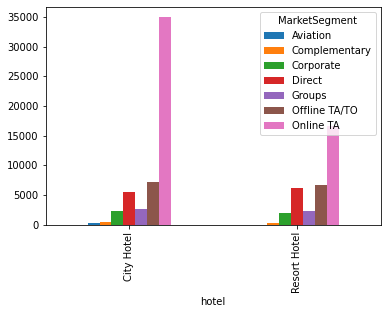

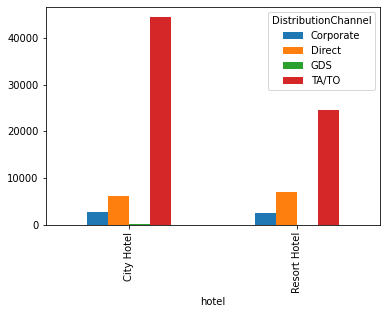

In [57]:
market_data=data1.groupby(["hotel","MarketSegment"]).size()
market_data=market_data.unstack()
market_data.plot(kind="bar")
distribution_data=data1.groupby(["hotel","DistributionChannel"]).size()
distribution_data=distribution_data.unstack()
distribution_data.plot(kind="bar")

<AxesSubplot:xlabel='hotel', ylabel='ArrivalMonth'>

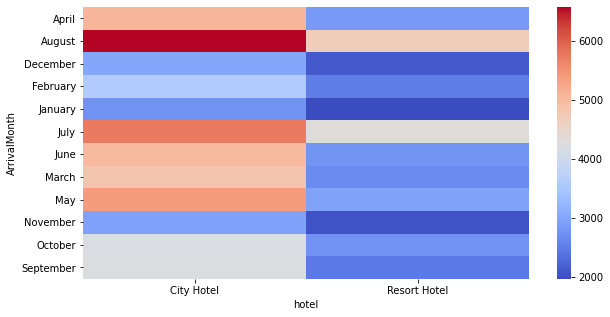

In [58]:
#TO find the busiest montth of the hotel-graph1-Monthly Cancellations and Customers by Hotel Types
fig, ax = plt.subplots(figsize=(10,5))         # Sample figsize in inches
sns.heatmap(pd.crosstab(data1.ArrivalMonth,data1.hotel),cmap="coolwarm",ax=ax)

Text(0, 0.5, 'Cancelled Rate')

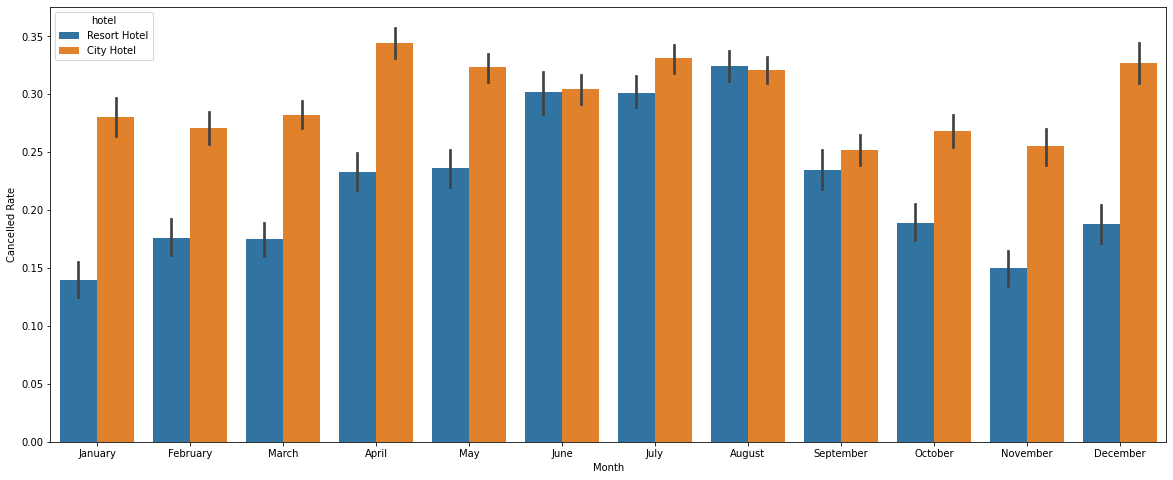

In [59]:
#overview of monthly cancellation ratio-graph1-Monthly Cancellations and Customers by Hotel Types
plt.figure(figsize=(20,8))
arrival_period=data.select('hotel', 'ArrivalMonth').toPandas()
sns.barplot(x = 'ArrivalMonth', y = 'Cancelled', hue = 'hotel', data = data1,order = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
        'August', 'September', 'October', 'November', 'December']);
plt.xlabel('Month')
plt.ylabel('Cancelled Rate')

Text(0.5, 1.0, 'Repeated Guests Cancellation Ratio')

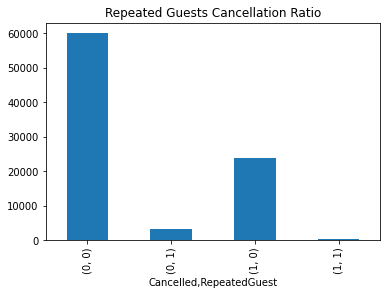

In [60]:
# There is no surprise that repeated guests do not cancel their reservations. Of course there are some exceptions. Also most of the customers are not repeated guests.
df1=data1.groupby(["Cancelled","RepeatedGuest"]).size()
df1.plot(kind="bar").set_title('Repeated Guests Cancellation Ratio', fontsize = '12')

Text(0.5, 1.0, 'Repeated Guests Cancellations Overview')

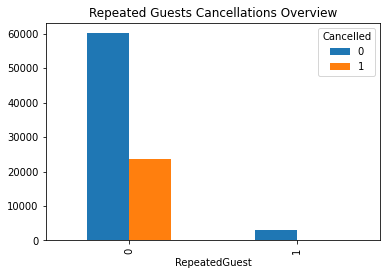

In [61]:
df1=data1.groupby(["RepeatedGuest","Cancelled"]).size()
df1=df1.unstack()
df1.plot(kind="bar").set_title('Repeated Guests Cancellations Overview', fontsize = '12')

Text(0, 0.5, 'ADR')

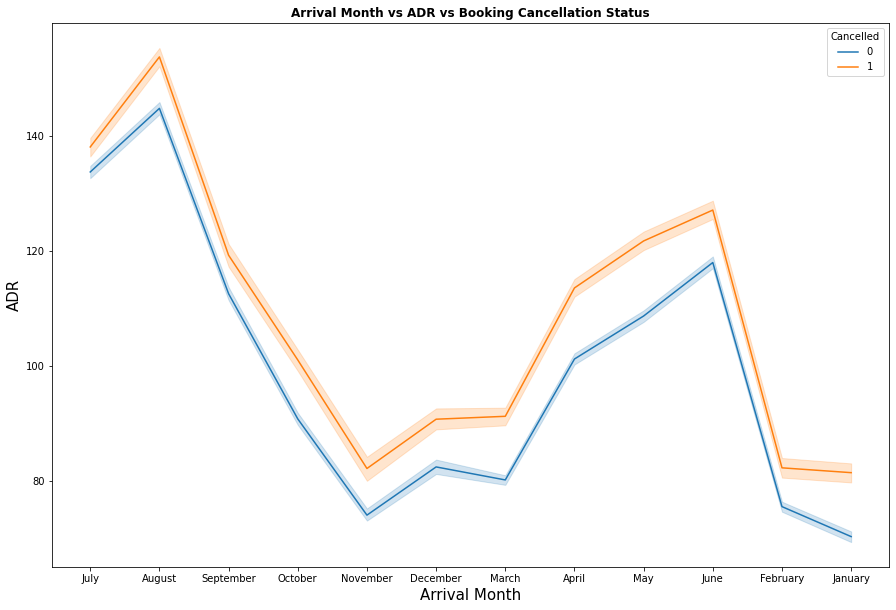

In [62]:
plt.figure(figsize=(15,10))
sns.lineplot(x='ArrivalMonth', y='AverageDailyRate', hue='Cancelled', data=data1)
plt.title('Arrival Month vs ADR vs Booking Cancellation Status', weight='bold')
plt.xlabel('Arrival Month', fontsize=15)
plt.ylabel('ADR', fontsize=15)

Text(0, 0.5, 'Count')

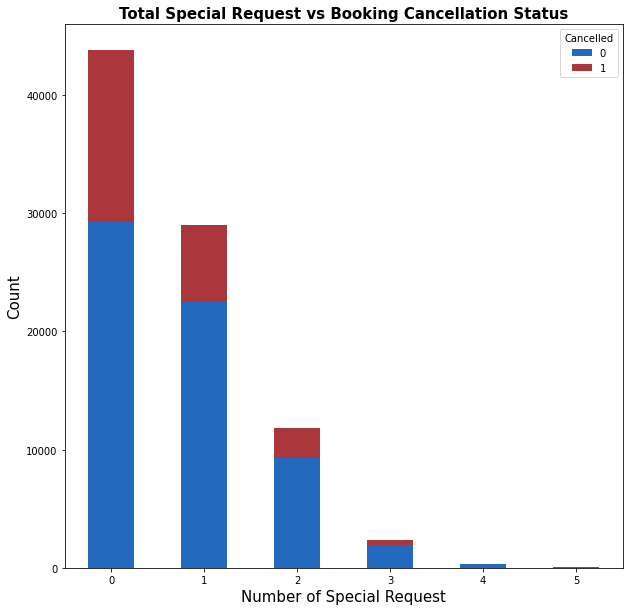

In [63]:
#graph3
group_adr_request = data1.groupby([ 'SpecialRequestRate', 'Cancelled']).size().unstack(fill_value=0)
group_adr_request.plot(kind='bar', stacked=True, cmap='vlag', figsize=(10,10))
plt.title('Total Special Request vs Booking Cancellation Status', weight='bold',size=15)
plt.xlabel('Number of Special Request', fontsize=15)
plt.xticks(rotation=360)
plt.ylabel('Count', fontsize=15)

In [64]:
CancelledData= data1[data1.Cancelled == 1]

Text(0.5, 0, 'Lead Time')

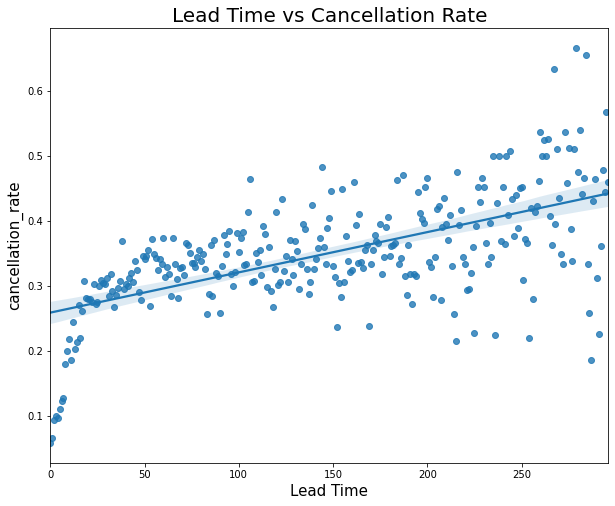

In [65]:
lead_time_count = data1.groupby('LeadTime')['Cancelled'].count()
lead_time_canceled_count = CancelledData.groupby('LeadTime')['Cancelled'].count()
cancellation_rate = lead_time_canceled_count / lead_time_count 
plt.figure(figsize = (10,8))
sns.regplot(cancellation_rate.index, cancellation_rate.values)
plt.title('Lead Time vs Cancellation Rate', fontsize = 20)
plt.ylabel('cancellation_rate',size=15)
plt.xlabel('Lead Time',size=15)

In [66]:
PreviousCancellations_count = data1.groupby('PreviousCancellations')['Cancelled'].count()
PreviousCancellations_canceled_count = CancelledData.groupby('PreviousCancellations')['Cancelled'].count()
PreviousCancellations_rate = PreviousCancellations_canceled_count / PreviousCancellations_count 
print(PreviousCancellations_rate)

PreviousCancellations
0     0.267285
1     0.761566
2     0.309091
3     0.262295
4     0.200000
5     0.105263
6     0.117647
11    0.074074
13    0.750000
14    1.000000
19    1.000000
21    1.000000
24    1.000000
25    1.000000
26    1.000000
Name: Cancelled, dtype: float64


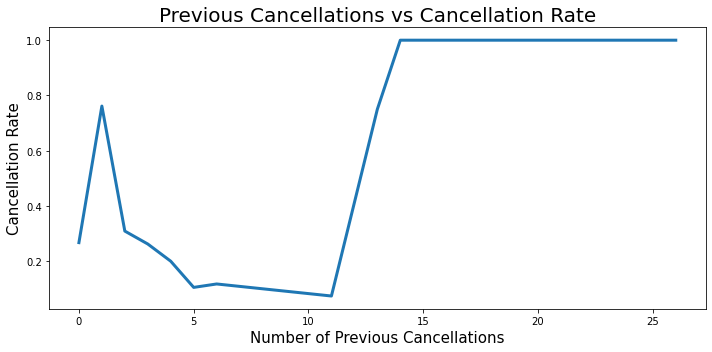

In [67]:
#graph5
PreviousCancellations_rate.plot(figsize= (10,5), linewidth=3)
plt.title("Previous Cancellations vs Cancellation Rate", size=20)
plt.xlabel("Number of Previous Cancellations", size=15)
plt.ylabel("Cancellation Rate", size=15)
plt.tight_layout()
plt.show()

In [45]:
from pyspark.ml.feature import(
OneHotEncoder,
   StringIndexer,
    VectorAssembler,
    StandardScaler,
    VectorSlicer
)
from pyspark.ml.classification import  RandomForestClassifier,LogisticRegression
from pyspark.ml import Pipeline

<AxesSubplot:xlabel='Cancelled', ylabel='count'>

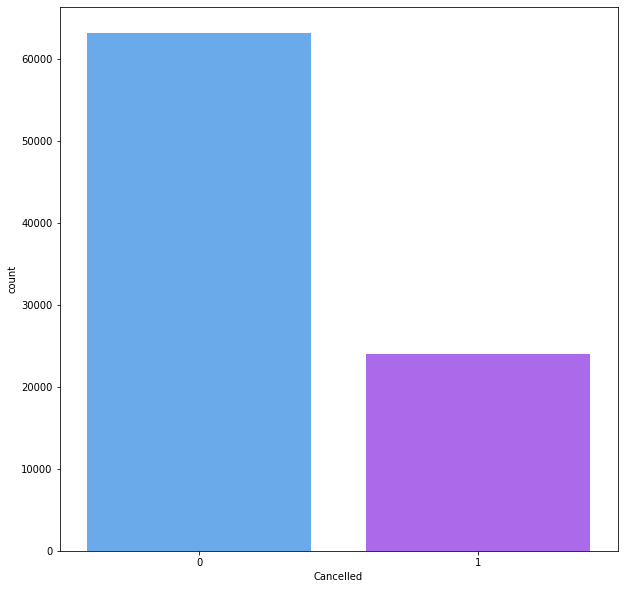

In [135]:
plt.figure(figsize=(10, 10))
sns.countplot(x='Cancelled', data=data.toPandas(), palette='cool')

In [46]:
#undersampling
majority=data.filter(f.col("Cancelled")==0)
minority=data.filter(f.col("Cancelled")==1)
sampleRatio = majority.count() / minority.count()
SampleDf = majority.sample(False, 1/sampleRatio)
data=SampleDf.unionAll(minority)

In [47]:
categorical_feature = [i[0] for i in data.dtypes if (i[1]=='string') & (i[0] !='country')]
num_feature = ["Cancelled","LeadTime","WeekendStay","WeekStay","adults","PreviousCancellations","WaitingListDays","AverageDailyRate"]
selected_columns=categorical_feature + num_feature
Filtered_Dataset=data.select(selected_columns)

In [48]:
Filtered_Dataset=Filtered_Dataset.withColumnRenamed('Cancelled', 'label')

In [49]:
numerical = [i[0] for i in Filtered_Dataset.dtypes if (i[1]!='string') & (i[0] !='label')]
stringIndex =[StringIndexer(inputCol = feature, outputCol = feature + 'stringIndexed', handleInvalid = 'skip') for feature in categorical_feature]
onehotIndex = [OneHotEncoder(inputCols = [feature + 'stringIndexed'], outputCols = [feature + '_OneHot']) for feature in categorical_feature]
assembler = VectorAssembler(inputCols = numerical + [feature + '_OneHot'for feature in categorical_feature], outputCol = "features")
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

In [50]:
pipeline = Pipeline(stages = stringIndex + onehotIndex + [assembler,rf])

In [ ]:
cols = Filtered_Dataset.columns
new_Dataset = pipeline.fit(Filtered_Dataset)
Transformed_Dataset = new_Dataset.transform(Filtered_Dataset)

In [75]:
Feature_scores=new_Dataset.stages[-1].featureImportances

In [76]:
metadata_list = []
for i in Transformed_Dataset.schema["features"].metadata["ml_attr"]["attrs"]:
     metadata_list = metadata_list + Transformed_Dataset.schema["features"].metadata["ml_attr"]["attrs"][i]
score_list = pd.DataFrame(metadata_list)
score_list['score'] = score_list['idx'].apply(lambda x: Feature_scores[x])
score_list=score_list.sort_values('score', ascending = False)
score_list

idx                                  name     score
0     0                              LeadTime  0.237799
25   25        MarketSegment_OneHot_Online TA  0.163020
26   26    MarketSegment_OneHot_Offline TA/TO  0.109084
31   31      DistributionChannel_OneHot_TA/TO  0.107804
35   35         DepositType_OneHot_Non Refund  0.087231
34   34         DepositType_OneHot_No Deposit  0.054015
4     4                 PreviousCancellations  0.047227
6     6                      AverageDailyRate  0.045922
37   37  customer_type_OneHot_Transient-Party  0.038055
36   36        customer_type_OneHot_Transient  0.034937
27   27           MarketSegment_OneHot_Direct  0.017780
2     2                              WeekStay  0.010296
32   32     DistributionChannel_OneHot_Direct  0.009359
28   28           MarketSegment_OneHot_Groups  0.005792
38   38         customer_type_OneHot_Contract  0.005556
1     1                           WeekendStay  0.004945
3     3                                adults  0.004892
29   29        MarketSegment_OneHot_Corporate  0.003525
23   23                        Meal_OneHot_SC  0.003254
7     7               hotel_OneHot_City Hotel  0.003039
33   33  DistributionChannel_OneHot_Corporate  0.002750
21   21                     children_OneHot_2  0.000644
12   12              ArrivalMonth_OneHot_June  0.000542
13   13             ArrivalMonth_OneHot_March  0.000421
18   18          ArrivalMonth_OneHot_November  0.000401
16   16          ArrivalMonth_OneHot_February  0.000390
22   22                        Meal_OneHot_BB  0.000345
15   15         ArrivalMonth_OneHot_September  0.000246
14   14           ArrivalMonth_OneHot_October  0.000216
5     5                       WaitingListDays  0.000183
9     9              ArrivalMonth_OneHot_July  0.000114
19   19                     children_OneHot_0  0.000054
11   11             ArrivalMonth_OneHot_April  0.000048
10   10               ArrivalMonth_OneHot_May  0.000035
30   30    MarketSegment_OneHot_Complementary  0.000030
17   17          ArrivalMonth_OneHot_December  0.000019
20   20                     children_OneHot_1  0.000016
8     8            ArrivalMonth_OneHot_August  0.000015
24   24                        Meal_OneHot_HB  0.000000

Text(0.5, 1.0, 'Top 3 Features')

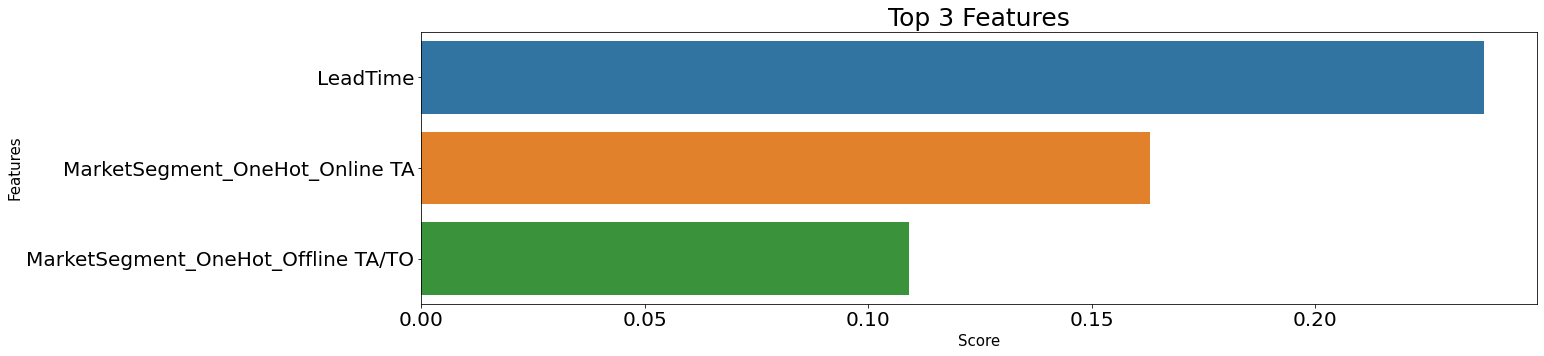

In [77]:
#overview of monthly cancellation ratio-graph1-Monthly Cancellations and Customers by Hotel Types
plt.figure(figsize=(20,5))
score_num = score_list.iloc[0:3]
sns.barplot(x = 'score', y = 'name', data = score_num).tick_params(labelsize=20)
plt.xlabel('Score',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.title("Top 3 Features",fontsize=25)

In [78]:
scoreidx = [x for x in score_list['idx'][0:10]]
scoreidx

[0, 25, 26, 31, 35, 34, 4, 6, 37, 36]

In [79]:
vector_slicer = VectorSlicer(inputCol="features", outputCol="Sliced_features", indices=scoreidx)
sliced_dataset = vector_slicer.transform(Transformed_Dataset)

In [80]:
sliced_dataset = sliced_dataset.drop('rawPrediction', 'probability', 'prediction')

In [81]:
train, test = sliced_dataset.randomSplit([0.7, 0.3])
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 33552
Test Dataset Count: 14420


In [82]:
rf2 = RandomForestClassifier(labelCol="label", featuresCol="Sliced_features")
mod2 = rf2.fit(train)
RandomForestClassifier_predictions = mod2.transform(test)

In [83]:
RandomForestClassifier_predictions.select(['label','probability','prediction']).show(10,False)

+-----+----------------------------------------+----------+
|label|probability                             |prediction|
+-----+----------------------------------------+----------+
|0    |[0.3538306851379401,0.6461693148620599] |1.0       |
|0    |[0.34067905531293263,0.6593209446870674]|1.0       |
|0    |[0.3579410647525296,0.6420589352474704] |1.0       |
|0    |[0.7023025220676079,0.29769747793239204]|0.0       |
|0    |[0.7079409797172075,0.2920590202827925] |0.0       |
|0    |[0.34067905531293263,0.6593209446870674]|1.0       |
|0    |[0.6397063874661355,0.3602936125338646] |0.0       |
|0    |[0.7257422368740845,0.27425776312591554]|0.0       |
|0    |[0.3538306851379401,0.6461693148620599] |1.0       |
|0    |[0.34184957043593106,0.658150429564069] |1.0       |
+-----+----------------------------------------+----------+
only showing top 10 rows



In [84]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(RandomForestClassifier_predictions))

Test Area Under ROC 0.7496133544756431


In [85]:
#confusion Matrix - using cross tab
RF_ConfusionMatrix = RandomForestClassifier_predictions.crosstab("prediction", "label")
RF_ConfusionMatrix = RF_ConfusionMatrix.toPandas()
RF_ConfusionMatrix

prediction_label     0     1
0              1.0  2597  5531
1              0.0  4558  1734

In [86]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
preds_and_labels = RandomForestClassifier_predictions.select(['prediction','label']).withColumn('label', f.col('label').cast(FloatType())).orderBy('prediction')
#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

[[4558. 2597.]
 [1734. 5531.]]
